In [1]:
%matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import params, trades, feats, plots, models_core
importlib.reload(params)
importlib.reload(trades)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)

<module 'libs.models_core' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_core.py'>

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy  as np
import math
import matplotlib.pyplot as plt

import datetime as dt
import os
from typing import Sequence, List, Tuple, Optional, Union

import torch.nn as nn
import torch.nn.functional as Funct
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts #, ReduceLROnPlateau
from torch.amp import GradScaler

from tqdm import tqdm

In [3]:
df_feat_sel = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[params.features_cols_tick + ['close_raw'] + [params.label_col]]
    
df_feat_sel

,sma_pct_14,atr_pct_14,rsi_14,bb_w_20,plus_di_14,range_pct,eng_ma,minus_di_14,macd_diff_12_26_9,ret,eng_macd,macd_line_12_26_9,obv_diff_14,eng_atr_div,eng_adx,hour,adx_14,close_raw,signal
2004-01-02 09:33:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.301415e-09
2004-01-02 09:34:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.405474e-09
2004-01-02 09:35:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.517855e-09
2004-01-02 09:36:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.639221e-09
2004-01-02 09:37:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.770291e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.751690,0.323886,0.672166,0.273759,0.363125,0.254109,0.532431,0.074852,0.888941,0.642346,0.634772,0.971125,1.000000,0.664288,0.537709,-0.975989,0.301944,196.815000,6.849078e-01
2025-06-18 20:57:00,0.650094,0.336016,0.616686,0.290460,0.347207,0.420131,0.532016,0.067044,0.840741,0.340442,0.633511,0.981544,0.000000,0.676887,0.541855,-0.975989,0.328685,196.675000,6.122057e-01
2025-06-18 20:58:00,0.631153,0.322169,0.614734,0.304199,0.336272,0.121620,0.531618,0.064933,0.777896,0.494192,0.631866,0.983006,0.000000,0.584662,0.545337,-0.975989,0.353515,196.670000,6.104678e-01
2025-06-18 20:59:00,0.375519,0.346959,0.475401,0.305249,0.290578,0.565110,0.531157,0.160021,0.456523,0.009795,0.623450,0.884486,0.000000,0.645760,0.531521,-0.975989,0.348960,196.240000,4.770902e-01


In [4]:
train_loader, val_loader, test_loader, end_times_tr, end_times_val, end_times_te = models_core.model_core_pipeline(
    df             = df_feat_sel,
    look_back      = params.look_back_tick,
    sess_start     = params.sess_start_pred_tick,
    train_prop     = params.train_prop,
    val_prop       = params.val_prop,
    train_batch    = params.hparams["TRAIN_BATCH"],
    num_workers    = params.hparams["NUM_WORKERS"],
    prefetch_factor= params.hparams["TRAIN_PREFETCH_FACTOR"],
    signal_thresh  = params.best_optuna_params["buy_threshold"],
    return_thresh  = params.return_threshold_tick
)

for name, ld, tm in zip(
    ["train","val","test"],
    [train_loader, val_loader, test_loader],
    [end_times_tr, end_times_val, end_times_te]
):
    models_core.summarize_split(name, ld, tm)

Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Preparing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

--- TRAIN ---
 calendar days : 3840  (2004-01-02 → 2019-04-04)
 windows       : 1731840  (per-day min=451, max=451, mean=451.0)
 window shape  : look_back=60, n_features=17
 dataloader    : batches= 60, batch_size=64, workers=12, pin_memory=True

--- VAL ---
 calendar days : 751  (2019-04-05 → 2022-03-28)
 windows       : 338701  (per-day min=451, max=451, mean=451.0)
 window shape  : look_back=60, n_features=17
 dataloader    : batches=751, batch_size=1, workers=0, pin_memory=True

--- TEST ---
 calendar days : 809  (2022-03-29 → 2025-06-18)
 windows       : 364859  (per-day min=451, max=451, mean=451.0)
 window shape  : look_back=60, n_features=17
 dataloader    : batches=809, batch_size=1, workers=0, pin_memory=True



In [5]:
# importlib.reload(params.model_selected) #############

# -----------------------------------------------------------------------------
# Instantiate the ModelClass & move to device
# -----------------------------------------------------------------------------

model = params.model_selected.ModelClass(
    n_feats          = len(params.features_cols_tick),                          
    short_units      = params.hparams['SHORT_UNITS'],    
    long_units       = params.hparams['LONG_UNITS'],     
    dropout_short    = params.hparams['DROPOUT_SHORT'],  
    dropout_long     = params.hparams['DROPOUT_LONG'],   
    # att_heads        = params.hparams['ATT_HEADS'],
    # att_drop         = params.hparams['ATT_DROPOUT'],
    conv_k           = params.hparams['CONV_K'],
    conv_dilation    = params.hparams['CONV_DILATION'],
    # smooth_k         = params.hparams['SMOOTH_K'],
    # smooth_dilation  = params.hparams['SMOOTH_DILATION']
    pred_hidden      = params.hparams['PRED_HIDDEN'],
)
model.to(params.device)  

model

ModelClass(
  (conv): Conv1d(17, 17, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn): BatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (short_lstm): LSTM(17, 96, batch_first=True, bidirectional=True)
  (ln_short): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  (do_short): Dropout(p=0.2, inplace=False)
  (short2long): Linear(in_features=192, out_features=256, bias=True)
  (ln_long): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (do_long): Dropout(p=0.2, inplace=False)
  (pred): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

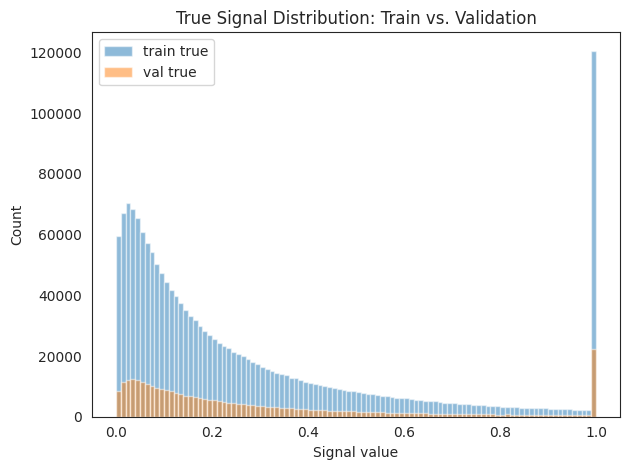

In [6]:
y_train = np.concatenate([batch[1].cpu().numpy().ravel() for batch in train_loader])
y_val = np.concatenate([batch[1].cpu().numpy().ravel() for batch in val_loader])

# Visualize the true‐signal distributions on train vs. validation
plt.hist(y_train, bins=100, alpha=0.5, label="train true")
plt.hist(y_val,   bins=100, alpha=0.5, label="val true")
plt.xlabel("Signal value")
plt.ylabel("Count")
plt.title("True Signal Distribution: Train vs. Validation")
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
# import numpy as np
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# import torch

# def full_sanity_check(train_loader, val_loader, model):
#     """
#     Run end-to-end sanity checks on:
#       1) _compute_metrics vs. sklearn
#       2) compute_baselines vs. manual baselines
#       3) eval_on_loader metrics vs. manual flatten+_compute_metrics
#     Raises AssertionError on any mismatch; prints summary if all pass.
#     """
#     # 1) Test _compute_metrics against sklearn on random data
#     rng = np.random.RandomState(42)
#     targs = rng.rand(50)
#     preds = rng.rand(50)
#     m = params.model_selected._compute_metrics(preds, targs)
#     mse = mean_squared_error(targs, preds)
#     assert np.isclose(m["rmse"], np.sqrt(mse), atol=1e-8), "RMSE mismatch"
#     assert np.isclose(m["mae"], mean_absolute_error(targs, preds), atol=1e-8), "MAE mismatch"
#     assert np.isclose(m["r2"], r2_score(targs, preds), atol=1e-8), "R2 mismatch"

#     # 2) Test compute_baselines vs. manual
#     def manual_baselines(loader):
#         nexts, pers_preds, pers_targs = [], [], []
#         for xb, y_r, *_ignore, wd, ts_list, lengths in loader:
#             for i, L in enumerate(lengths):
#                 if L < 1: continue
#                 y = y_r[i, :L].view(-1).cpu().numpy()
#                 nexts.append(y[-1])
#                 if L > 1:
#                     pers_preds.append(y[-2])
#                     pers_targs.append(y[-1])
#         nexts = np.array(nexts, dtype=float)
#         mean_rmse_manual = float(np.sqrt(((nexts - nexts.mean())**2).mean()))
#         if pers_preds:
#             pers_preds = np.array(pers_preds)
#             pers_targs = np.array(pers_targs)
#             pers_rmse_manual = float(np.sqrt(((pers_preds - pers_targs)**2).mean()))
#         else:
#             pers_rmse_manual = float("nan")
#         return mean_rmse_manual, pers_rmse_manual

#     # run on train_loader and val_loader
#     for name, loader in [("TRAIN", train_loader), ("VAL", val_loader)]:
#         base_mean_fn, base_pers_fn = params.model_selected.compute_baselines(loader)
#         mean_m, pers_m = manual_baselines(loader)
#         assert np.isclose(base_mean_fn, mean_m, atol=1e-8), f"{name} mean baseline mismatch"
#         assert np.isclose(base_pers_fn, pers_m, atol=1e-8), f"{name} persistence baseline mismatch"

#     # 3) Test eval_on_loader vs. manual flatten + _compute_metrics
#     def manual_eval(loader):
#         all_preds, all_targs = [], []
#         device = next(model.parameters()).device
#         model.to(device).eval()
#         model.h_short = model.h_long = None
#         prev_day = None
#         with torch.no_grad():
#             for xb, y_reg, *_ignore, wd, ts_list, lengths in loader:
#                 xb, y_reg, wd = xb.to(device), y_reg.to(device), wd.to(device)
#                 B = xb.size(0)
#                 for i in range(B):
#                     prev_day = params.model_selected._reset_states(model, wd[i], prev_day)
#                     W = int(lengths[i])
#                     if W == 0: continue
#                     seqs = xb[i, :W]
#                     raw = model(seqs)
#                     raw_reg = raw[0] if isinstance(raw, (tuple,list)) else raw
#                     if raw_reg.dim()==3 and raw_reg.size(-1)!=1:
#                         raw_reg = model.pred(raw_reg)
#                     elif raw_reg.dim()==2:
#                         raw_reg = model.pred(raw_reg.unsqueeze(0)).squeeze(0)
#                     preds_win = raw_reg.squeeze(-1)[:, -1]
#                     targs_win = y_reg[i, :W].view(-1)
#                     all_preds.extend(preds_win.cpu().tolist())
#                     all_targs.extend(targs_win.cpu().tolist())
#         preds = np.array(all_preds, dtype=float)
#         targs = np.array(all_targs, dtype=float)
#         return params.model_selected._compute_metrics(preds, targs)

#     # run manual_eval on val_loader and compare to eval_on_loader
#     manual_metrics = manual_eval(val_loader)
#     fn_metrics, _      = params.model_selected.eval_on_loader(val_loader, model)
#     for key in ("rmse", "mae", "r2"):
#         assert np.isclose(fn_metrics[key], manual_metrics[key], atol=1e-8), \
#             f"eval_on_loader {key} mismatch: {fn_metrics[key]} vs {manual_metrics[key]}"

#     print("✅ FULL SANITY CHECK PASSED: metrics, baselines, eval align perfectly.")

# full_sanity_check(train_loader, val_loader, model)

In [8]:
# import numpy as np
# import torch

# def metrics_proof(loader, model):
#     # 1) Re-compute mean‐baseline and persistence‐baseline by hand
#     manual_nexts, manual_deltas = [], []
#     for xb, y_r, *_ignored, wd, ts, lengths in loader:
#         for i, L in enumerate(lengths):
#             if L < 1: 
#                 continue
#             y = y_r[i, :L].view(-1).cpu().numpy()
#             manual_nexts.append(y[-1])
#             if L > 1:
#                 manual_deltas.append(y[-1] - y[-2])

#     nxt = np.array(manual_nexts, dtype=float)
#     deltas = np.array(manual_deltas, dtype=float)
#     mean_rmse_manual = np.sqrt(((nxt - nxt.mean())**2).mean())
#     pers_rmse_manual = np.sqrt((deltas**2).mean())

#     # 2) Call your compute_baselines()
#     mean_rmse_fn, pers_rmse_fn = params.model_selected.compute_baselines(loader)

#     # 3) Flatten preds/targs via eval_on_loader (no clamp)
#     (metrics, preds) = params.model_selected.eval_on_loader(loader, model)
#     # we need the targets too—so do a tiny mod:
#     #   return _compute_metrics(preds,targs), preds, targs
#     # in eval_on_loader, then unpack here:
#     #    metrics, preds, targs = eval_on_loader(...)
#     # For now we’ll reconstruct targs manually:
#     all_targs = []
#     for xb, y_r, *_ignored, wd, ts, lengths in loader:
#         for i, L in enumerate(lengths):
#             if L < 1:
#                 continue
#             all_targs.extend(y_r[i, :L].view(-1).cpu().tolist())
#     targs = np.array(all_targs[: len(preds) ], dtype=float)

#     manual_rmse_flat = np.sqrt(((preds - targs)**2).mean())

#     print(f"Mean baseline:  fn={mean_rmse_fn:.5f}  manual={mean_rmse_manual:.5f}")
#     print(f"Pers baseline:  fn={pers_rmse_fn:.5f}  manual={pers_rmse_manual:.5f}")
#     print(f"Eval RMSE:      fn={metrics['rmse']:.5f}  flat={manual_rmse_flat:.5f}")
#     print("Sample deltas:", deltas[:10])
#     print("Sample preds:", preds[:10])
#     print("Sample targs:", targs[:10])

#     assert np.isclose(mean_rmse_fn, mean_rmse_manual, atol=1e-8)
#     assert np.isclose(pers_rmse_fn, pers_rmse_manual, atol=1e-8)
#     assert np.isclose(metrics['rmse'], manual_rmse_flat, atol=1e-8)
#     print("✅ All RMSEs and baselines match the textbook formula exactly.")

# # Run it on train then val
# metrics_proof(train_loader, model)
# metrics_proof(val_loader,   model)


Training sees 3840 unique trading days per epoch.

Using HyperParameters:
 "look_back": 60 {'CONV_K': 3, 'CONV_DILATION': 1, 'SHORT_UNITS': 192, 'DROPOUT_SHORT': 0.2, 'LONG_UNITS': 256, 'PRED_HIDDEN': 128, 'DROPOUT_LONG': 0.2, 'LR_EPOCHS_WARMUP': 3, 'INITIAL_LR': 0.0001, 'WEIGHT_DECAY': 0.0002, 'CLIPNORM': 2, 'ETA_MIN': 1e-06, 'T_0': 10, 'T_MULT': 2, 'TRAIN_BATCH': 64, 'VAL_BATCH': 1, 'NUM_WORKERS': 12, 'TRAIN_PREFETCH_FACTOR': 4, 'MAX_EPOCHS': 100, 'EARLY_STOP_PATIENCE': 7}


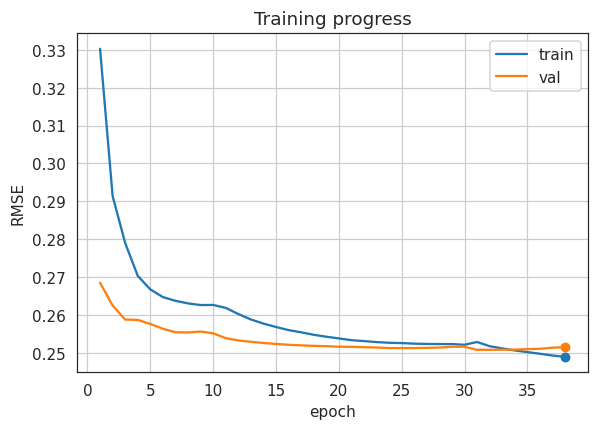

Epoch 1 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 01  TRAIN RMSE=0.33029  VALID RMSE=0.26851


Epoch 2 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 02  TRAIN RMSE=0.29140  VALID RMSE=0.26248


Epoch 3 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 03  TRAIN RMSE=0.27899  VALID RMSE=0.25878


Epoch 4 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 04  TRAIN RMSE=0.27031  VALID RMSE=0.25869


Epoch 5 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 05  TRAIN RMSE=0.26675  VALID RMSE=0.25762


Epoch 6 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 06  TRAIN RMSE=0.26471  VALID RMSE=0.25635


Epoch 7 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 07  TRAIN RMSE=0.26374  VALID RMSE=0.25543


Epoch 8 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 08  TRAIN RMSE=0.26305  VALID RMSE=0.25537


Epoch 9 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 09  TRAIN RMSE=0.26261  VALID RMSE=0.25561


Epoch 10 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 10  TRAIN RMSE=0.26265  VALID RMSE=0.25515


Epoch 11 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 11  TRAIN RMSE=0.26186  VALID RMSE=0.25387


Epoch 12 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 12  TRAIN RMSE=0.26026  VALID RMSE=0.25327


Epoch 13 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 13  TRAIN RMSE=0.25881  VALID RMSE=0.25291


Epoch 14 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 14  TRAIN RMSE=0.25771  VALID RMSE=0.25259


Epoch 15 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 15  TRAIN RMSE=0.25682  VALID RMSE=0.25234


Epoch 16 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 16  TRAIN RMSE=0.25599  VALID RMSE=0.25212


Epoch 17 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 17  TRAIN RMSE=0.25542  VALID RMSE=0.25197


Epoch 18 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 18  TRAIN RMSE=0.25476  VALID RMSE=0.25183


Epoch 19 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 19  TRAIN RMSE=0.25425  VALID RMSE=0.25175


Epoch 20 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 20  TRAIN RMSE=0.25380  VALID RMSE=0.25161


Epoch 21 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 21  TRAIN RMSE=0.25334  VALID RMSE=0.25158


Epoch 22 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 22  TRAIN RMSE=0.25310  VALID RMSE=0.25150


Epoch 23 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 23  TRAIN RMSE=0.25283  VALID RMSE=0.25140


Epoch 24 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 24  TRAIN RMSE=0.25265  VALID RMSE=0.25125


Epoch 25 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 25  TRAIN RMSE=0.25257  VALID RMSE=0.25125


Epoch 26 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 26  TRAIN RMSE=0.25242  VALID RMSE=0.25126


Epoch 27 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 27  TRAIN RMSE=0.25235  VALID RMSE=0.25131


Epoch 28 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 28  TRAIN RMSE=0.25231  VALID RMSE=0.25138


Epoch 29 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 29  TRAIN RMSE=0.25231  VALID RMSE=0.25159


Epoch 30 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 30  TRAIN RMSE=0.25213  VALID RMSE=0.25160


Epoch 31 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 31  TRAIN RMSE=0.25286  VALID RMSE=0.25078


Epoch 32 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 32  TRAIN RMSE=0.25174  VALID RMSE=0.25080


Epoch 33 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 33  TRAIN RMSE=0.25117  VALID RMSE=0.25082


Epoch 34 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 34  TRAIN RMSE=0.25063  VALID RMSE=0.25084


Epoch 35 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 35  TRAIN RMSE=0.25019  VALID RMSE=0.25098


Epoch 36 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 36  TRAIN RMSE=0.24975  VALID RMSE=0.25106


Epoch 37 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Epoch 37  TRAIN RMSE=0.24928  VALID RMSE=0.25134


Epoch 38 ▶ Train:   0%|          | 0/60 [00:00<?, ?it/s]

eval:   0%|          | 0/751 [00:00<?, ?it/s]

Early stopping at epoch 38
✅ Final‐best model saved: AAPL_0.25078_fin.pth


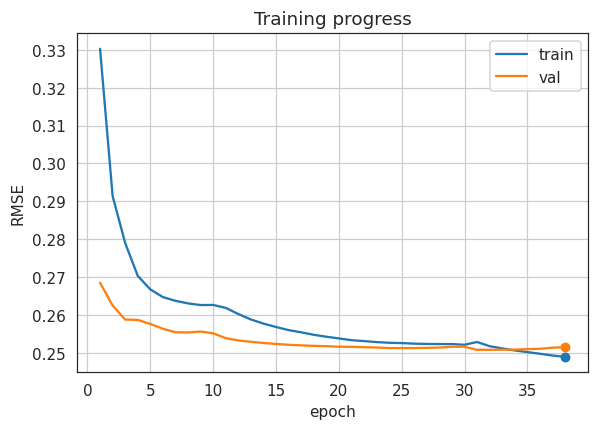

In [11]:
importlib.reload(params.model_selected) #############
importlib.reload(models_core) #############

# How many unique trading days does each epoch see?
n_days = len(train_loader.dataset)
print(f"Training sees {n_days} unique trading days per epoch.\n")

print('Using HyperParameters:\n "look_back":', params.look_back_tick, params.hparams)


optimizer = AdamW(
    model.parameters(),
    lr=params.hparams['INITIAL_LR'],
    weight_decay=params.hparams['WEIGHT_DECAY']
)

cosine_sched = CosineAnnealingWarmRestarts(
    optimizer,
    T_0   = params.hparams['T_0'],
    T_mult= params.hparams['T_MULT'],
    eta_min=params.hparams['ETA_MIN']
)

# -----------------------------------------------------------------------------
# Run the custom stateful training loop
# -----------------------------------------------------------------------------
best_val_rmse  = params.model_selected.model_training_loop(
    model               = model,
    optimizer           = optimizer,
    cosine_sched        = cosine_sched,
    # plateau_sched       = plateau_sched,
    scaler              = GradScaler(),
    train_loader        = train_loader,
    val_loader          = val_loader,
    max_epochs          = params.hparams['MAX_EPOCHS'],
    early_stop_patience = params.hparams['EARLY_STOP_PATIENCE'],
    clipnorm            = params.hparams['CLIPNORM'],
    # cls_loss_weight     = params.hparams['CLS_LOSS_WEIGHT'],
    # smooth_alpha        = params.hparams['SMOOTH_ALPHA'],
    # smooth_beta         = params.hparams['SMOOTH_BETA'],
    # smooth_delta        = params.hparams['SMOOTH_DELTA'],
    # diff1_weight        = params.hparams['DIFF1_WEIGHT'],
    # diff2_weight        = params.hparams['DIFF2_WEIGHT'],
)
